# Models

## Common Code

Common functions for training and fine-tuning the BERT models.

In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print("INIT module_path: ", module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = module_path + "/data"
MODEL_DIR = module_path + "/model"

for data_dir in [DATA_DIR, MODEL_DIR]:
    os.makedirs(data_dir, exist_ok=True)

INIT module_path:  c:\Users\Alan\Desktop\Open_Source\BERT-TLSA-paper


In [2]:
from transformers import BertTokenizerFast
import pandas as pd
import torch
from typing import TypedDict, cast


class TokenizedInputs(TypedDict):
    input_ids: torch.IntTensor
    token_type_ids: torch.IntTensor
    attention_mask: torch.IntTensor
    labels: torch.IntTensor


class MaskedTextDatasetItem(TokenizedInputs):
    original_text: str


class MaskedTextDataset(torch.utils.data.Dataset[MaskedTextDatasetItem]):
    def __init__(self, encodings: TokenizedInputs, original_text: list[str] = None):
        self.encodings = encodings
        self.original_text = original_text

    def __getitem__(self, index: int) -> MaskedTextDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        return res
    
    def __len__(self):
        return len(self.encodings["input_ids"])
    
    def to(self, device: torch.device):
        for key in self.encodings:
            if isinstance(self.encodings[key], torch.Tensor):
                self.encodings[key] = cast(torch.Tensor, self.encodings[key]).to(device=device)


def read_review_texts(data_file: str = "myanimelist_reviews.csv") -> list[str]:
    data_df = pd.read_csv(f"{DATA_DIR}/{data_file}")
    return data_df["review"].astype(str).to_list()

def get_masked_dataset(tokenizer: BertTokenizerFast, review_texts: list[str], percent_masked: float = 0.15, dataset_file: str = "") -> MaskedTextDataset:
    if dataset_file:
        print(f"Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            masked_text_dataset: MaskedTextDataset = torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False)
            return masked_text_dataset
        except Exception as e:
            print(f"Error loading dataset file: {e}")
    print(f"Creating new dataset file @ {dataset_file}...")
    encodings: TokenizedInputs = tokenizer(review_texts, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    # Create a new field labels that is a clone of input_ids
    encodings["labels"] = encodings["input_ids"].detach().clone()
    # In BERT paper, each token has 15% chance of being masked
    # First, create random vector that spans all of the input_ids (spans all the tokens)
    rand = torch.rand(encodings["input_ids"].shape)
    # (rand < 0.15) -> Any token that has a corresponding random value of < 0.15, we mask
    # We also don't want to mask special tokens (101, 102), and padding tokens (0)
    # * operator is elementwise multiplication, which is same as AND for boolean tensors
    mask_arr = (rand < percent_masked) * (encodings["input_ids"] != 101) * (encodings["input_ids"] != 0) * (encodings["input_ids"] != 102)
    # Stores all the indices that we want to mask
    masked_cols = []
    # Iterate over each row in the mask_arr (basically each sentence in our text data)
    for i in range(mask_arr.shape[0]):
        # .nonzero() -> finds the indicies where we have "true" values (since true = 1 and false = 0 in pytorch)
        masked_cols.append(mask_arr[i].nonzero().flatten().tolist())
    # Apply our mask_arr in each row (each sentence)
    for i in range(mask_arr.shape[0]):
        # Special Tensor syntax -> we can pass in a list of indicies for any of the axes
        #   In this case, we pass in a list of indices in the column axis, to effectively
        #   select the columns (tokens) we want to mask out
        encodings["input_ids"][i, masked_cols[i]] = 103
    masked_text_dataset = MaskedTextDataset(encodings, review_texts)
    torch.save(masked_text_dataset, f"{DATA_DIR}/{dataset_file}")
    return masked_text_dataset

In [3]:
from transformers import BertTokenizerFast, BertForMaskedLM, BertConfig
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class TrainingConfig:
    def __init__(self, tokenizer: BertTokenizerFast, model: BertForMaskedLM, optim: torch.optim.Optimizer, epochs: int = 20, name: str = "model"):
        self.tokenizer = tokenizer
        self.model = model
        self.optim = optim
        self.epochs = epochs
        self.name = name
    
    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self)


def build_training_config(pretrained_model: bool = False, pretrained_model_name: str = "bert-base-uncased", epochs: int = 20, name: str = "model") -> TrainingConfig:
    # NOTE: We are not re-training a tokenizer, since it's out of the scope of this experiment
    tokenizer: BertTokenizerFast = BertTokenizerFast.from_pretrained(pretrained_model_name)
    if pretrained_model:
        # Create tokenizer + already trained model
        model: BertForMaskedLM = BertForMaskedLM.from_pretrained(pretrained_model_name)
    else:
        config = BertConfig(
            vocab_size=tokenizer.vocab_size,
            max_position_embeddings=512,
            hidden_size=256,
            num_hidden_layers=4,
            num_attention_heads=4,
            type_vocab_size=2,
        )
        model: BertForMaskedLM = BertForMaskedLM(config)
    # Create the optimizer
    optim = torch.optim.AdamW(model.parameters(), lr=1e-5)
    # Move the model to the device we speicified
    #   Ideally use CUDA (GPU) if available
    model.to(device)
    return TrainingConfig(tokenizer, model, optim, epochs, name)

print(f"Training on device: {device}")

Training on device: cuda


In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
from transformers.modeling_outputs import MaskedLMOutput
from typing import cast, Iterator
import matplotlib.pyplot as plt

class TrainingLogData:
    def __init__(self, epoch: int, loss: int):
        self.epoch = epoch
        self.loss = loss
    
    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self)


def pretraining_loop(dataloader: torch.utils.data.DataLoader[MaskedTextDatasetItem], config: TrainingConfig) -> list[TrainingLogData]:
    model, optim = config.model, config.optim
    log_data: list[TrainingLogData] = []
    
    model_dir = f"{MODEL_DIR}/{config.name}/"
    os.makedirs(model_dir, exist_ok=True)
    
    print(f"Pretraining start for '{config.name}'...")
    for epoch in range(config.epochs):
        loop = tqdm(cast(Iterator[MaskedTextDatasetItem], dataloader), leave=True)
        for data in loop:
            # Reset gradient
            optim.zero_grad()

            outputs: MaskedLMOutput = model(data["input_ids"], attention_mask=data["attention_mask"], labels=data["labels"])
            loss = outputs.loss

            # Apply backward propagation
            loss.backward()
            optim.step()

            # Set info in tqdm progress bar
            loop.set_description(f"Epoch: {epoch}")
            loop.set_postfix(loss=loss.item())
        log_data.append(TrainingLogData(epoch=epoch, loss=loss.item()))
        epochs = [x.epoch for x in log_data]
        for key in dir(log_data[0]):
            if key.startswith("_") or key == "epoch":
                continue
            plt.plot(epochs, [getattr(item, key) for item in log_data])
        plt.plot()
        clear_output(wait=True)
        plt.show()
        torch.save({
            "model": model.state_dict,
            "optim": optim.state_dict,
            "log_data": log_data,
        }, model_dir + f"model_{epoch}.pt")
  

# def finetuning_loop(dataloader: torch.utils.data.DataLoader[MaskedTextDatasetItem], config: TrainingConfig) -> list[TrainingLogData]:
#     for data in dataloader:
#         data = cast(MaskedTextDatasetItem, data)

## MyAnimeList

Training BERT on MyAnimeList only.

In [5]:
review_texts = read_review_texts("myanimelist_reviews.csv")
review_texts[:10]

['Oh dear Shingeki no Kyojin, where do I even begin. If you\'ve talked with your friends about anime, then the couple anime that everyone talks about are Naruto, Bleach, One Piece, Dragon Ball, and... Shingeki no Kyojin. What\'s the difference between Shingeki and the rest? Shingeki only has 25 episodes so far yet it\'s on par in popularity with the other super long, Americanized anime. Why is it popular? Well that\'s simply because it\'s stunningly amazing. Those people that call Shingeki no Kyojin "overrated" may not have the same taste as me, and that\'s perfectly fine, but in my honest opinion, Shingeki no Kyojin isone of if not the greatest anime to be made. It\'s not popular for no reason.\n\nThe story is one of the most captivating stories I\'ve ever seen. 100 years prior to the start of the anime, humanity has been on the bridge of extinction due to the monstrous humanoid Titans that devour humans. Now, present day in the anime, the remaining small population of mankind lives c

In [10]:
config = build_training_config(name="myanimelist")
config

{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'model': BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embed

In [7]:
masked_dataset = get_masked_dataset(config.tokenizer, review_texts, dataset_file="myanimelist_masked_data.dt")
masked_dataset.to(device)

Loading existing dataset file @ myanimelist_masked_data.dt...


In [8]:
dataloader = torch.utils.data.DataLoader(masked_dataset, batch_size=32, shuffle=True)
next(iter(dataloader))

{'input_ids': tensor([[  101, 17012,  2092,  ...,     0,     0,     0],
         [  101,  2089,  5383,  ...,  5128,   103,   102],
         [  101,  3071,   103,  ...,  2023,  2126,   102],
         ...,
         [  101,  1045,   103,  ...,     0,     0,     0],
         [  101,  1000,  2000,  ...,   103,  2003,   102],
         [  101, 23649,  2011,  ...,  1012,  2008,   102]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'),
 'labels': tensor([[  101, 17012,  2092,  ...,     0,     0,     0],
         

In [ ]:
pretraining_loop(dataloader, config)

## Steam

Training BERT on Steam only.

In [ ]:
review_texts = read_review_texts("steam_reviews.csv")
review_texts[:10]

["Amazing game. Easily 30-40 hours of game play. I hope the dev continues to add more depth in the future! I'd love to see,- More zones, cities, villages etc- Additional starting scenarios (in debt, being a dealer for someone else, certain supplies/drugs not available)- Setups (undercover cops/narcs)- Raids/counter-raids (Police/cartel)- Thief's stealing supplies (if door left open, or employees turning against you)- Mixing drugs with other drugs (weed w/ cocaine)- Turf wars w/ opponent drug-lord organisation charts that you can war with, slowly discover their hierarchy and order hits or do them yourself- High volume deals (shipping supplies off to other regions)",
 'For a just "released in early access game" the devs managed to make a game that works, have a fun gameplay loop and satisfying pacing in growth. I would like to see:- a search function in the product management app- a way to change the strain\'s name after the fact, not only when you \'discover\' it. - some one or faction 

In [ ]:
config = build_training_config(name="steam")
config

{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'model': BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embed

In [ ]:
masked_dataset = get_masked_dataset(config.tokenizer, review_texts, dataset_file="steam_masked_data.dt")
masked_dataset.to(device)

Loading existing dataset file @ steam_masked_data.dt...


In [ ]:
dataloader = torch.utils.data.DataLoader(masked_dataset, batch_size=32, shuffle=True)
next(iter(dataloader))

{'input_ids': tensor([[  101,  1996, 14903,  ...,     0,     0,     0],
         [  101,  2009,   103,  ...,   999,  2926,   102],
         [  101,  2026,  6513,  ...,     0,     0,     0],
         ...,
         [  101,  2026,  2767,  ...,     0,     0,     0],
         [  101,  2045,  2024,  ...,     0,     0,     0],
         [  101,  2823,  2043,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': tensor([[  101,  1996, 14903,  ...,     0,     0,     0],
         

In [ ]:
pretraining_loop(dataloader, config)

Epoch: 4: 100%|██████████| 668/668 [01:10<00:00,  9.45it/s, loss=0.47] 


## Metacritic

Training BERT on Metacritic only.

In [11]:
review_texts = read_review_texts("metacritic_reviews.csv")
review_texts[:10]

['Boring game that was soulless even in the beginning. Its contemporaries Roadblocks (why is this censored lol) and Blockland do everything better. Easily the most overrated game of all time.',
 'the best, the only, the unique game in its genre.\nThis game gave me my childhood, THIS IS THE BEST GAME',
 'Not my cup of tea due to so many choices. Still pretty great. Memorable style of world. Diverse & expansive gameplay. Major impact on the industry.',
 'Film He was Very average More I gave Credit By the References And also For the Nostalgia The jokes They are not Funny One Except Put Some well Specific More on al He was Good More or less',
 'Minecraft é muito criativo, dá muita liberdade para os jogadores, possui um vasto lore próprio, muitos detalhes, investimento e desenvolvimento contínuo ao longo de anos após o lançamento, meus amigo sempre gostaram, sempre foi muito popular no youtube e na twitch...\n\nE mesmo assim eu nunca gostei tanto. Talvez pelo gênero de sobrevivência que não

In [12]:
config = build_training_config(name="metacritic")
config

{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'model': BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embed

In [13]:
masked_dataset = get_masked_dataset(config.tokenizer, review_texts, dataset_file="metacritic_masked_data.dt")
masked_dataset.to(device)

Loading existing dataset file @ metacritic_masked_data.dt...
Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/metacritic_masked_data.dt'
Creating new dataset file @ metacritic_masked_data.dt...


In [14]:
dataloader = torch.utils.data.DataLoader(masked_dataset, batch_size=32, shuffle=True)
next(iter(dataloader))

{'input_ids': tensor([[  101, 10657,   103,  ...,     0,     0,     0],
         [  101, 21113,  4527,  ...,     0,     0,     0],
         [  101,  2023,  2208,  ...,     0,     0,     0],
         ...,
         [  101,   103,  2209,  ...,     0,     0,     0],
         [  101,  3819,   102,  ...,     0,     0,     0],
         [  101,  1009,   103,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': tensor([[  101, 10657,  2022,  ...,     0,     0,     0],
         

Epoch: 19: 100%|██████████| 269/269 [00:28<00:00,  9.51it/s, loss=0.178]


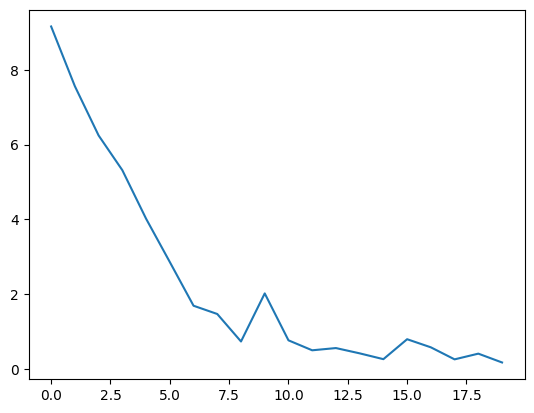

In [15]:
pretraining_loop(dataloader, config)

## Rotten Tomatoes

Training BERT on Rotten Tomatoes only.

In [ ]:
review_texts = read_review_texts("rotten_tomatoes_reviews.csv")
review_texts[:10]

["Amazing game. Easily 30-40 hours of game play. I hope the dev continues to add more depth in the future! I'd love to see,- More zones, cities, villages etc- Additional starting scenarios (in debt, being a dealer for someone else, certain supplies/drugs not available)- Setups (undercover cops/narcs)- Raids/counter-raids (Police/cartel)- Thief's stealing supplies (if door left open, or employees turning against you)- Mixing drugs with other drugs (weed w/ cocaine)- Turf wars w/ opponent drug-lord organisation charts that you can war with, slowly discover their hierarchy and order hits or do them yourself- High volume deals (shipping supplies off to other regions)",
 'For a just "released in early access game" the devs managed to make a game that works, have a fun gameplay loop and satisfying pacing in growth. I would like to see:- a search function in the product management app- a way to change the strain\'s name after the fact, not only when you \'discover\' it. - some one or faction 

In [ ]:
config = build_training_config(name="rotten_tomatoes")
config

{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'model': BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embed

In [ ]:
masked_dataset = get_masked_dataset(config.tokenizer, review_texts, dataset_file="rotten_tomatoes_masked_data.dt")
masked_dataset.to(device)

Loading existing dataset file @ steam_masked_data.dt...


In [ ]:
dataloader = torch.utils.data.DataLoader(masked_dataset, batch_size=32, shuffle=True)
next(iter(dataloader))

{'input_ids': tensor([[  101,  1996, 14903,  ...,     0,     0,     0],
         [  101,  2009,   103,  ...,   999,  2926,   102],
         [  101,  2026,  6513,  ...,     0,     0,     0],
         ...,
         [  101,  2026,  2767,  ...,     0,     0,     0],
         [  101,  2045,  2024,  ...,     0,     0,     0],
         [  101,  2823,  2043,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': tensor([[  101,  1996, 14903,  ...,     0,     0,     0],
         

In [ ]:
pretraining_loop(dataloader, config)

Epoch: 4: 100%|██████████| 668/668 [01:10<00:00,  9.45it/s, loss=0.47] 
